In [1]:
import torch

In [2]:
import numpy as np
import pandas as pd

In [3]:
#import torchvision

In [3]:
#import timm

In [3]:
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt

In [5]:
# print all columns
pd.set_option('display.max_columns', None)

In [6]:
import os

In [7]:
import datetime

In [8]:
from scipy.interpolate import CubicSpline

In [9]:
import matplotlib.pyplot as plt

In [106]:
# try to redo timedelta with time
from datetime import datetime

Load trajectory

In [10]:
BASE_PATH = '/Volumes/Experiment Data/Sasha and Or/'

Variables

In [12]:
# list of participants - ignore hidden files/folders (.DS_Store)
part_set = set([_dir for _dir in os.listdir(BASE_PATH) if not _dir.startswith(".")])

In [13]:
len(part_set)

38

In [14]:
exclude_set = set(['DL','OL','SM'])

In [15]:
PART_LIST = list(part_set - exclude_set)

In [16]:
len(PART_LIST)

35

In [54]:
# 125 hz
FREQ = 0.008

In [67]:
START_DELTA = 0.0 
# first 100 stimuli * 3 seconds each
# timedelta starts with 0 st second 300 is the right edge
# add one more time bracket for interpolation before trimming
END_DELTA = 300.0 
END_MINUTE = 6

Helper functions

In [17]:
def load_events(part):
    events_path = BASE_PATH+part+'/Events.csv'
    _events_df = pd.read_csv(events_path,on_bad_lines='warn')
    
    _simset = int(_events_df.columns[1].split('_')[1])
    
    _imgs = np.array([int(_events_df.loc[img][0]) for img in _events_df.index])
    
    _onsets = pd.Series([onset[0] for onset in _events_df.index],name='unity_time')
    _onsets = _onsets.apply(lambda x:x/1E7)
    # first line contains a timestamp but no "Looking" tag or eye data - ignore?
    #_events_onsets.insert(0,int(_events_df.columns[0]))
    print(str(len(_imgs)),'stimuli,',str(len(_onsets)),'events onsets' ,'- participant',part)
    # return pd.Series(_events_onsets,name='unity_time').apply(lambda x: x/1E7), _simset
    return _onsets, _simset, _imgs

In [ ]:
# Guess
# head_cols = ['Time',	'headx',	'heady',	'headz',	'head rot x',	head rot y	head rot z	head_dir_x	head_dir_y	head_dir_z]

In [ ]:
# def load_headDir(part):
#     head_path = BASE_PATH+part+'/position.csv'
#     _head_df = pd.read_csv(events_path,on_bad_lines='warn')
    
#     _cols = head_cols
#     # take intersection of head direction and gaze data?
    
#     return _head_df

columns - 
['confidence', 'GazeDirection_x', 'GazeDirection_y', 'GazeDirection_z',
       'GazeDistance', 'timestamp', 'norm_pos_x', 'norm_pos_y', 'EyeCenter0_x',
       'EyeCenter0_y', 'EyeCenter0_z', 'GazeNormal0_x', 'GazeNormal0_y',
       'GazeNormal0_z', 'EyeCenter1_x', 'EyeCenter1_y', 'EyeCenter1_z',
       'GazeNormal1_x', 'GazeNormal1_y', 'GazeNormal1_z', 'eyes_dir_hit_x',
       'eyes_dir_hit_y', 'eyes_dir_hit_z', 'eyes_to_surface_distance',
       'eyes_to_surface_angle', 'eyes_dir_name', 'unity_time',
       'TimeSinceStart', 'EyeID', 'Unnamed: 29']

In [18]:
# As per ofer rec to Sasha. R<>Sasha meet 7.6.22
gaze_cols = ['confidence', 'norm_pos_x', 'norm_pos_y', 'timestamp','unity_time', 'TimeSinceStart']

In [48]:
def load_binocular(part,events,cols=None):
    events_path = BASE_PATH+part+'/Gaze data.csv'
    _gaze_df = pd.read_csv(events_path,on_bad_lines='warn')
    
    _cols = cols if cols else _gaze_df.columns
    
    BINgaze_df = _gaze_df[_gaze_df['EyeID']=='Binocular'][_cols]
    BINgaze_df['unity_time'] = BINgaze_df['unity_time'].apply(lambda x: x/1E7)
        
    # time since the Beginning in unity-time seconds
    # unity time associates gaze data in Gaze data.csv with events onsets in Events.csv
    BINgaze_df['timedelta'] = BINgaze_df['unity_time'] - events[0]
    
    # cast as datetime for resampling, interpolation
    # "pre 1970" is negative time, time before first event onset
    BINgaze_df['timedelta_dt'] = pd.to_datetime(BINgaze_df['timedelta'],unit='s')
    # first data point from onset 
    # start_delta = 0.0
    BINgaze_df = BINgaze_df[BINgaze_df['timedelta'] >= START_DELTA ]
    BINgaze_df = BINgaze_df.reset_index(drop=True)
    
    return BINgaze_df

In [119]:
def fillfirstna(resampled_df,orig_df):
    # gaze_sample.loc[ar_gaze_sample['timedelta']>0].index[0] should be equivalent to ar_gaze_sample.iloc[0] if reset index to start_delta ie timedelta >=0
    if resampled_df.iloc[0].isna().all() and orig_df.iloc[0]['timedelta'] >= START_DELTA:
            resampled_df.iloc[0] = orig_df.iloc[0][resampled_df.columns]
    # TODO elif second clause make more flex for closest in time
    return resampled_df


def resample_and_interpolate(gaze_df,interp_cols,ffill=False):
    
    # mod ffill method to only return resampled time points 
    if ffill:
        resampled_df = gaze_df.set_index('timedelta_dt').resample('{hz}S'.format(hz=FREQ)).ffill()
        gaze_df = gaze_df.set_index('timedelta_dt')
        # if no data at the 0th time mark, will be na because ffill 
        # fill onset gaze loc with "original" (closest) value 
        resampled_df = fillfirstna(gaze_df,resampled_df)
        # resampledInterspersed_df = resampledCat_df.sort_values(by='timedelta_dt')
        resampled_df = resampled_df[resampled_df.index.minute < END_MINUTE]
    # cubic spline interpolation
    else:
        # returns empty dataframe indexed at frequency
        NaNresampled_df = gaze_df.set_index('timedelta_dt').resample('{hz}S'.format(hz=FREQ)).interpolate()
        gaze_df = gaze_df.set_index('timedelta_dt')
        # should be zero overlap between timestamps since original report is to nanosecond and resampling is by the millisecond
        # concats back-to-back
        resampledCat_df = pd.concat([NaNresampled_df,gaze_df])
        # order by time - nan rows interspersed with reported values
        resampledInterspersed_df = resampledCat_df.sort_values(by='timedelta_dt')
        # (Cubic spline) interpolation between resampled points
        CSresampled_df = resampledInterspersed_df[interp_cols].interpolate(method='cubicspline')
        
        # take only the resampled time rows
        resampled_df = CSresampled_df.loc[NaNresampled_df.index]
        
        resampled_df = fillfirstna(resampled_df,gaze_df)
        
        # resampled_df = resampled_df[resampled_df.index.minute < END_MINUTE]
        # keep right fencepost
        resampled_df = resampled_df[(resampled_df.index <= datetime(year=1970,month=1,day=1,minute=END_MINUTE,second=0))]
        
    return resampled_df 

def gaze_input_tensor(gaze_df,return_cols=['norm_pos_x','norm_pos_y']):
    resampled_df = resample_and_interpolate(gaze_df,interp_cols=return_cols)
    return torch.tensor(resampled_df.values)

In [17]:
# events_dict = {}
# for part in PART_LIST:
    # try:
    #     onsets, simset, imgs = load_events(part)
    #     events_dict[part+'_events'] = onsets
    #     events_dict[part+'_simset'] = simset
    #     events_dict[part+'_imgs'] = imgs
    # except FileNotFoundError as e:
    #     print(e)

122 stimuli, 122 events onsets - participant AR
122 stimuli, 122 events onsets - participant DI
122 stimuli, 122 events onsets - participant DM
122 stimuli, 122 events onsets - participant IL
122 stimuli, 122 events onsets - participant IS
122 stimuli, 122 events onsets - participant MA
122 stimuli, 122 events onsets - participant NC
122 stimuli, 122 events onsets - participant NCH
122 stimuli, 122 events onsets - participant NH
122 stimuli, 122 events onsets - participant NT
124 stimuli, 124 events onsets - participant OA
122 stimuli, 122 events onsets - participant OB
122 stimuli, 122 events onsets - participant RB
122 stimuli, 122 events onsets - participant RN
122 stimuli, 122 events onsets - participant SG
122 stimuli, 122 events onsets - participant SHB
122 stimuli, 122 events onsets - participant SHM
122 stimuli, 122 events onsets - participant SSW
122 stimuli, 122 events onsets - participant TL
122 stimuli, 122 events onsets - participant VT
122 stimuli, 122 events onsets - par

In [19]:
# test
ar_events_series, ar_simset, ar_imgs_arr = load_events('AR')

122 stimuli, 122 events onsets - participant AR


In [51]:
ar_gaze_df = load_binocular('AR',events=ar_events_series,cols=gaze_cols)

In [53]:
ar_gaze_df.head()

,confidence,norm_pos_x,norm_pos_y,timestamp,unity_time,TimeSinceStart,timedelta,timedelta_dt
0,1.00000,0.603335,-0.251901,152.883091,4014.632130,152.9777,0.001034,1970-01-01 00:00:00.001033900
1,0.94489,0.606151,-0.247742,152.887935,4014.632171,152.9777,0.001075,1970-01-01 00:00:00.001075300
2,0.94489,0.605414,-0.256802,152.890226,4014.659948,153.0055,0.028852,1970-01-01 00:00:00.028852399
3,1.00000,0.601761,-0.253033,152.892312,4014.659989,153.0055,0.028893,1970-01-01 00:00:00.028893199
4,1.00000,0.603854,-0.251132,152.896237,4014.660020,153.0056,0.028924,1970-01-01 00:00:00.028924100


In [52]:
ar_gaze_df.dtypes

confidence               float64
norm_pos_x               float64
norm_pos_y               float64
timestamp                float64
unity_time               float64
TimeSinceStart           float64
timedelta                float64
timedelta_dt      datetime64[ns]
dtype: object

Resample with forward fill - missing much of the granularity

In [113]:
ar_gaze_resampled = resample_and_interpolate(ar_gaze_df)

In [114]:
ar_gaze_df.head()

,confidence,norm_pos_x,norm_pos_y,timestamp,unity_time,TimeSinceStart,timedelta,timedelta_dt
0,1.00000,0.603335,-0.251901,152.883091,4014.632130,152.9777,0.001034,1970-01-01 00:00:00.001033900
1,0.94489,0.606151,-0.247742,152.887935,4014.632171,152.9777,0.001075,1970-01-01 00:00:00.001075300
2,0.94489,0.605414,-0.256802,152.890226,4014.659948,153.0055,0.028852,1970-01-01 00:00:00.028852399
3,1.00000,0.601761,-0.253033,152.892312,4014.659989,153.0055,0.028893,1970-01-01 00:00:00.028893199
4,1.00000,0.603854,-0.251132,152.896237,4014.660020,153.0056,0.028924,1970-01-01 00:00:00.028924100


In [115]:
ar_gaze_resampled.head()

,norm_pos_x,norm_pos_y
timedelta_dt,,
1970-01-01 00:00:00.000,0.603335,-0.251901
1970-01-01 00:00:00.008,1.075943,0.005425
1970-01-01 00:00:00.016,1.408222,-0.321605
1970-01-01 00:00:00.024,1.174222,-0.532017
1970-01-01 00:00:00.032,-0.170017,0.106299


In [116]:
ar_gaze_resampled.tail()

,norm_pos_x,norm_pos_y
timedelta_dt,,
1970-01-01 00:05:59.968,0.464119,-0.307525
1970-01-01 00:05:59.976,0.652363,-0.079985
1970-01-01 00:05:59.984,0.469805,-0.153029
1970-01-01 00:05:59.992,0.247078,-0.020280
1970-01-01 00:06:00.000,0.299245,-0.021139


In [118]:
ar_gaze_resampled.shape

(45001, 2)

In [120]:
ar_gaze_input_tensor = gaze_input_tensor(ar_gaze_df)

In [121]:
ar_gaze_input_tensor

tensor([[ 0.6033, -0.2519],
        [ 1.0759,  0.0054],
        [ 1.4082, -0.3216],
        ...,
        [ 0.4698, -0.1530],
        [ 0.2471, -0.0203],
        [ 0.2992, -0.0211]], dtype=torch.float64)

In [122]:
ar_gaze_input_tensor.shape

torch.Size([45001, 2])

Events

In [123]:
ar_simset

12

In [124]:
ar_imgs_arr

array([50, 82, 78, 71, 97, 86,  7, 64, 51, 99, 58, 44, 41, 85, 73, 12, 95,
       66, 15, 83, 87, 23, 31,  4, 54, 29, 16, 96, 92, 56, 70, 24, 38, 89,
       25, 88,  1, 49, 34, 19, 94, 62, 28, 75, 67, 81, 36, 46, 69, 11, 55,
       84,  2, 47, 53, 20, 48, 91, 35, 32, 93,  5, 33, 37, 60, 40, 77, 74,
       52,  0, 63, 72, 27, 80, 68, 22, 10,  8,  6,  3, 98, 76, 65, 79, 21,
       30,  9, 57, 59, 42, 18, 90, 39, 26, 13, 45, 17, 61, 43, 14, 73, 97,
       20, 93, 35, 95, 97, 23, 92, 71, 10, 85, 55,  0,  1, 33, 60, 40, 99,
       67, 31, 24])

In [125]:
ar_events_series

0      4014.631096
1      4017.656451
2      4020.683983
3      4023.710307
4      4026.738614
          ...     
117    4368.490379
118    4371.517478
119    4374.545062
120    4377.560591
121    4380.588651
Name: unity_time, Length: 122, dtype: float64

In [126]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [127]:
def decode_image_from_simset_and_label(simset,label):
    return x_train[np.where(y_train==label)[0][simset-1]]

In [128]:
img = decode_image_from_simset_and_label(simset=ar_simset,label=ar_imgs_arr[0])

In [129]:
img.shape

(32, 32, 3)

In [130]:
torch.tensor(decode_image_from_simset_and_label(simset=ar_simset,label=ar_imgs_arr[1])).shape

torch.Size([32, 32, 3])

In [131]:
imgs = torch.stack([torch.tensor(decode_image_from_simset_and_label(simset=ar_simset,label=ar_imgs_arr[:5])),torch.tensor(decode_image_from_simset_and_label(simset=ar_simset,label=ar_imgs_arr[1]))])

In [132]:
imgs.shape

torch.Size([2, 32, 32, 3])

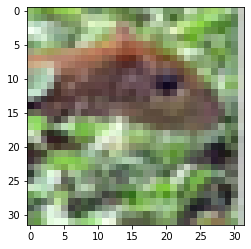

In [133]:
plt.imshow(img)

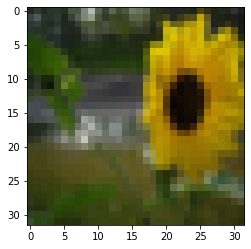

In [134]:
plt.imshow(imgs[1])

In [20]:
cifar_vit = timm.create_model('vit_base_patch16_224_miil_in21k', pretrained=True)

In [137]:
# cifar_vit.eval()

In [136]:
# from pprint import pprint
# model_names = timm.list_models(pretrained=True)
# pprint(model_names)